In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q evaluate transformers datasets mlflow

In [3]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

4000 4000


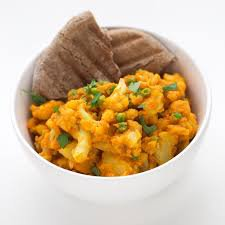

In [18]:
image_dict = {}
from pathlib import Path
from tqdm import tqdm
file_names = []
labels = []
for file in sorted((Path('/kaggle/input/indian-food-images-dataset/Indian Food Images/Indian Food Images').glob('*/*.jpg'))):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[90]["image"]

In [5]:
labels[90:91]

['aloo_gobi']

In [6]:
file_names[90:91]

['/kaggle/input/indian-food-images-dataset/Indian Food Images/Indian Food Images/aloo_gobi/6f21bcc3db.jpg']

In [19]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id) 

{0: 'aloo_gobi', 1: 'daal_puri', 2: 'bhindi_masala', 3: 'boondi', 4: 'lassi', 5: 'modak', 6: 'kuzhi_paniyaram', 7: 'sandesh', 8: 'dharwad_pedha', 9: 'pootharekulu', 10: 'makki_di_roti_sarson_da_saag', 11: 'palak_paneer', 12: 'misti_doi', 13: 'aloo_matar', 14: 'aloo_shimla_mirch', 15: 'litti_chokha', 16: 'aloo_tikki', 17: 'chhena_kheeri', 18: 'chapati', 19: 'cham_cham', 20: 'sheer_korma', 21: 'daal_baati_churma', 22: 'naan', 23: 'bandar_laddu', 24: 'jalebi', 25: 'ghevar', 26: 'dum_aloo', 27: 'kofta', 28: 'rasgulla', 29: 'butter_chicken', 30: 'kadai_paneer', 31: 'maach_jhol', 32: 'ras_malai', 33: 'aloo_methi', 34: 'phirni', 35: 'shrikhand', 36: 'qubani_ka_meetha', 37: 'dal_tadka', 38: 'rabri', 39: 'kajjikaya', 40: 'bhatura', 41: 'navrattan_korma', 42: 'basundi', 43: 'chicken_tikka_masala', 44: 'poha', 45: 'chicken_tikka', 46: 'gajar_ka_halwa', 47: 'gavvalu', 48: 'kalakand', 49: 'dal_makhani', 50: 'malapua', 51: 'misi_roti', 52: 'shankarpali', 53: 'doodhpak', 54: 'ledikeni', 55: 'sheera',

In [34]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})


In [36]:
dataset =dataset.train_test_split(test_size =0.15)

In [40]:

train_data = dataset['train']
print(len(train_data))
test_data= dataset['test']


3400


In [39]:
# print(f"{test_data[1]['label']}")

double_ka_meetha


In [ ]:
test_data[1]['image']

In [42]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [43]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [44]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [45]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.860176


In [46]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [48]:
metric_name = "accuracy"
model_name = "indian_food_image_detection"
num_train_epochs=30
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)



In [49]:
trainer.evaluate()

Trainer is attempting to log a value of "{0: 'aloo_gobi', 1: 'daal_puri', 2: 'bhindi_masala', 3: 'boondi', 4: 'lassi', 5: 'modak', 6: 'kuzhi_paniyaram', 7: 'sandesh', 8: 'dharwad_pedha', 9: 'pootharekulu', 10: 'makki_di_roti_sarson_da_saag', 11: 'palak_paneer', 12: 'misti_doi', 13: 'aloo_matar', 14: 'aloo_shimla_mirch', 15: 'litti_chokha', 16: 'aloo_tikki', 17: 'chhena_kheeri', 18: 'chapati', 19: 'cham_cham', 20: 'sheer_korma', 21: 'daal_baati_churma', 22: 'naan', 23: 'bandar_laddu', 24: 'jalebi', 25: 'ghevar', 26: 'dum_aloo', 27: 'kofta', 28: 'rasgulla', 29: 'butter_chicken', 30: 'kadai_paneer', 31: 'maach_jhol', 32: 'ras_malai', 33: 'aloo_methi', 34: 'phirni', 35: 'shrikhand', 36: 'qubani_ka_meetha', 37: 'dal_tadka', 38: 'rabri', 39: 'kajjikaya', 40: 'bhatura', 41: 'navrattan_korma', 42: 'basundi', 43: 'chicken_tikka_masala', 44: 'poha', 45: 'chicken_tikka', 46: 'gajar_ka_halwa', 47: 'gavvalu', 48: 'kalakand', 49: 'dal_makhani', 50: 'malapua', 51: 'misi_roti', 52: 'shankarpali', 53: 

{'eval_loss': 4.3932952880859375,
 'eval_accuracy': 0.006666666666666667,
 'eval_runtime': 16.3493,
 'eval_samples_per_second': 36.699,
 'eval_steps_per_second': 2.324}

In [52]:
train_data[4]['image'].size

(640, 422)

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,4.317153,0.058333
2,No log,4.199899,0.206667
3,No log,4.070528,0.391667
4,No log,3.939126,0.460000
5,4.091400,3.814783,0.493333
6,4.091400,3.701141,0.518333
7,4.091400,3.597270,0.553333
8,4.091400,3.501384,0.588333
9,4.091400,3.417327,0.601667
10,3.443700,3.334978,0.608333


TrainOutput(global_step=3210, training_loss=2.9436794863311673, metrics={'train_runtime': 3196.2632, 'train_samples_per_second': 31.912, 'train_steps_per_second': 1.004, 'total_flos': 7.909708670631936e+18, 'train_loss': 2.9436794863311673, 'epoch': 30.0})

In [55]:
trainer.evaluate()

{'eval_loss': 2.6674070358276367,
 'eval_accuracy': 0.7066666666666667,
 'eval_runtime': 8.7997,
 'eval_samples_per_second': 68.184,
 'eval_steps_per_second': 4.318,
 'epoch': 30.0}

In [56]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 2.6674070358276367, 'test_accuracy': 0.7066666666666667, 'test_runtime': 8.9571, 'test_samples_per_second': 66.986, 'test_steps_per_second': 4.242}


In [58]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [59]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7067
F1 Score: 0.6847


In [60]:
trainer.save_model()

In [62]:
from transformers import pipeline

pipe = pipeline('image-classification',model=model_name,device=0)

In [66]:
image = "https://i1.wp.com/www.happyandharried.com/wp-content/uploads/2018/06/KOZHIKODAN-CHICKEN-BIRYANI-HAPPYHARRIED.jpg"

image 

'https://i1.wp.com/www.happyandharried.com/wp-content/uploads/2018/06/KOZHIKODAN-CHICKEN-BIRYANI-HAPPYHARRIED.jpg'

In [68]:
pipe(image)[0]['label']

'biryani'

In [71]:
import shutil

# Create a zip archive of the output directory
shutil.make_archive("model_output", 'zip', "output")


'/kaggle/working/model_output.zip'

In [83]:
!mkdir -p ~/.kaggle
!echo '{"username":"<sree>","key":"<123>"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


/bin/bash: line 1: /root/.kaggle/kaggle.json: Is a directory


In [85]:
!kaggle datasets download -u <sree> -d <model_output.zip> -p /kaggle/working


/bin/bash: line 1: sree: No such file or directory
